# Stage 2

On this stage we want to compare the performance of a small neural model trained (BERT) on two different types of annotations:
    (1) annotations generated using the best method from the first stage of the project,
    (2) the original, ground-truth annotations provided in the Coll2003 dataset.

Importing required libraries:

In [2]:
%pip install --quiet datasets seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.2 MB/s eta 0:00:00


In [46]:
from datasets import load_dataset
from collections import defaultdict, Counter
from tqdm import trange, tqdm
from dataclasses import dataclass
import shutil
import pathlib
import os
import sys
import json
import itertools
import re
import multiprocessing

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset, Subset, ConcatDataset
from torch.nn.utils.rnn import pad_sequence
from torch.multiprocessing import Pool, set_start_method

import numpy as np
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertModel, BertForTokenClassification
import torch.nn.functional as F
from seqeval.metrics import accuracy_score, f1_score, classification_report

from huggingface_hub import HfApi, PyTorchModelHubMixin, interpreter_login, snapshot_download, Repository, create_branch

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
shutil.copytree("/content/drive/MyDrive/nerc_test_task_model", "/content/", dirs_exist_ok=True)

'/content/'

Make a repository for a future models.

In [7]:
interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

Enter your token (input will not be visible): ··········
Add token as git credential? (Y/n) Y


In [8]:
username = HfApi().whoami()["name"]
REPO_NAME = f"{username}/nerc-extraction"

HfApi().create_repo(repo_id=REPO_NAME, private=False, exist_ok=True)

print(f"Repository: '{REPO_NAME}'")

Repository: 'estnafinema0/nerc-extraction'


In [9]:

API_URL = "https://llm.ispras.ru/api/chat/completions"
API_MODEL_URL = "https://llm.ispras.ru/api/models"
API_KEY = "YOUR_TOKEN"
# with open('./secrets') as file:
#     data: dict = json.load(file)
#     API_KEY = data.get('API_KEY', 'FAILED TO LOAD')

HIDDEN = 512
NER_TAGS = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
ADDITIONAL = {"[CLS]": 9, "[SEP]": 10, "X": 11}
NER_TAGS.update(ADDITIONAL)
TAGS_COUNT = len(NER_TAGS)
DATABASE_DIR = './data'
EMBEDDINGS_PATH = f'{DATABASE_DIR}/embeddings.txt'
CWD = '~/Рабочий стол/NERC_LLM_Ispras/data'
BERT_MODEL = 'bert-base-cased'
BATCH_SIZE = 32
EPOCHS = 5
INV_NER_TAGS = {v: k for k, v in NER_TAGS.items()}
PERCENTAGES = [.01, .02, .05, .1, .25, .5, 1.]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
LOAD_FROM_REPO = False


## Initalizing Neural Network Model

Model will consist of:
    (1) *pre-trained BERT model* for word embeddings, which captures contextual information effectively.
    (2) *bidirectional LSTM (BiLSTM) layer* to process the sequence of embeddings and capture dependencies between words.
    (3) *linear layer* to map the LSTM outputs to the NER tags.

In [10]:
class NERSmall(BertForTokenClassification, PyTorchModelHubMixin, repo_url=REPO_NAME, license="mit"):
    def forward(self, input_ids, attention_mask=None, token_type_ids=None,
                position_ids=None, head_mask=None, labels=None, label_masks=None):
        outputs = self.bert(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            position_ids=position_ids,
                            head_mask=head_mask)

        sequence_output = outputs[0]  # (b, MAX_LEN, 768)

        token_reprs = [embedding[mask] for mask, embedding in zip(label_masks, sequence_output)]
        token_reprs = pad_sequence(sequences=token_reprs, batch_first=True,
                                   padding_value=-1)  # (b, local_max_len, 768)
        sequence_output = self.dropout(token_reprs)
        logits = self.classifier(sequence_output)  # (b, local_max_len, num_labels)

        outputs = (logits,)
        if labels is not None:
            labels = [label[mask] for mask, label in zip(label_masks, labels)]
            labels = pad_sequence(labels, batch_first=True, padding_value=-1)  # (b, local_max_len)
            loss_fct = nn.CrossEntropyLoss(ignore_index=-1, reduction='sum')
            mask = labels != -1
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            loss /= mask.float().sum()
            outputs = (loss,) + outputs + (labels,)

        return outputs  # (loss), scores, (hidden_states), (attentions)


## Parsing and Loading Data

To organize the data, we define a simple data structure `InputExample`:

In [11]:
@dataclass
class InputExample:
    guid: str
    text: str
    ner_tag: list[str]

We make `parse_dataformat` function to processe raw text data, splitting it into sentences and their corresponding NER tags. We make it handle empty lines and document separators. It organizes the data into a list of InputExample objects.

In [12]:
def parse_dataformat(base_data: str, set_type: str) -> list[InputExample]:
    data = []
    sentence = []
    ner_tags = []
    for line in base_data.splitlines():
        if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
            if len(sentence) > 0:
                data.append((sentence, ner_tags))
                sentence = []
                ner_tags = []
            continue
        splits = line.split(' ')
        sentence.append(splits[0])
        ner_tags.append(splits[-1])

    if len(sentence) > 0:
        data.append((sentence, ner_tags))
        sentence = []
        ner_tags = []

    return [InputExample(f'{set_type}-{i}', ' '.join(sentence), ner_tag) for i, (sentence, ner_tag) in enumerate(data)]

def load_example(filepath, name) -> tuple[list[InputExample], list[InputExample], list[InputExample]]:
    with open(filepath) as file:
        file_data = file.read()
    return parse_dataformat(file_data, name)

def load_examples(data_dir) -> tuple[list[InputExample], list[InputExample], list[InputExample]]:
    return (load_example(pathlib.Path.joinpath(pathlib.Path(data_dir), 'test.txt'), 'test'),
            load_example(pathlib.Path.joinpath(pathlib.Path(data_dir), 'train.txt'), 'train'),
            load_example(pathlib.Path.joinpath(pathlib.Path(data_dir), 'valid.txt'), 'valid'))

## Custom Dataset


Now we need to create `NERDataSet` class that prepares the data for training. It tokenizes the input text, maps NER tags to their corresponding IDs, and pads sequences to a fixed length. The __getitem__ method processes each example by adding special tokens [CLS] and [SEP], tokenizing the text, and creating attention masks and sentence IDs. The method returns tensors for input IDs, NER tag IDs, attention masks, sentence IDs, and tag masks, which are used by the model during training.

## Training Environment

We are using BERT Tokenizer from `from_pretrained`.

The dataset is loaded into training, validation, and test sets using the load_examples function. DataLoader objects are created for each dataset, enabling efficient batching and shuffling of the data during training and evaluation.

In [13]:
class NERDataSet(Dataset):
    def __init__(self, data: list[InputExample], tokenizer: BertTokenizer, ner_tag_map: dict[str, int], max_len: int = 128):
        self._max_len = max_len
        self._ner_tag_map = ner_tag_map
        self._data = data
        self._tokenizer = tokenizer

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx: int):
        input_example = self._data[idx]

        text = input_example.text
        ner_tags = input_example.ner_tag
        word_tokens = ['[CLS]']
        ner_tag_list = ['[CLS]']
        ner_tag_mask = [0]  # value in {0,1} -- 0 signifies invalid token

        input_ids = [self._tokenizer.convert_tokens_to_ids('[CLS]')]
        ner_tag_ids = [self._ner_tag_map['[CLS]']]

        for word, ner_tag in zip(text.split(), ner_tags):
            tokenized_word = self._tokenizer.tokenize(word)

            word_tokens.extend(tokenized_word)
            assert len(tokenized_word) > 0
            input_ids.extend(map(self._tokenizer.convert_tokens_to_ids, tokenized_word))

            ner_tag_list.append(ner_tag)
            ner_tag_ids.append(self._ner_tag_map[ner_tag])
            ner_tag_mask.append(1)
            # len(tokenized_word) > 1 only if it splits word in between, in which case
            # the first token gets assigned NER tag and the remaining ones get assigned
            # X
            ner_tag_list.extend(itertools.repeat('X', len(tokenized_word) - 1))
            ner_tag_ids.extend(itertools.repeat(self._ner_tag_map['X'], len(tokenized_word) - 1))
            ner_tag_mask.extend(itertools.repeat(0, len(tokenized_word) - 1))

        assert len(word_tokens) == len(ner_tag_list) == len(input_ids) == len(ner_tag_ids) == len(ner_tag_mask)

        if len(word_tokens) >= self._max_len:
            word_tokens = word_tokens[:(self._max_len - 1)]
            ner_tag_list = ner_tag_list[:(self._max_len - 1)]
            input_ids = input_ids[:(self._max_len - 1)]
            ner_tag_ids = ner_tag_ids[:(self._max_len - 1)]
            ner_tag_mask = ner_tag_mask[:(self._max_len - 1)]

        assert len(word_tokens) < self._max_len, len(word_tokens)

        word_tokens.append('[SEP]')
        ner_tag_list.append('[SEP]')
        input_ids.append(self._tokenizer.convert_tokens_to_ids('[SEP]'))
        ner_tag_ids.append(self._ner_tag_map['[SEP]'])
        ner_tag_mask.append(0)

        assert len(word_tokens) == len(ner_tag_list) == len(input_ids) == len(ner_tag_ids) == len(ner_tag_mask)

        sentence_id = [0] * len(input_ids)
        attention_mask = [1] * len(input_ids)

        left = self._max_len - len(input_ids)
        input_ids.extend(itertools.repeat(0, left))
        ner_tag_ids.extend(itertools.repeat(self._ner_tag_map['X'], left))
        attention_mask.extend(itertools.repeat(0, left))
        sentence_id.extend(itertools.repeat(0, left))
        ner_tag_mask.extend(itertools.repeat(0, left))


        assert len(word_tokens) == len(ner_tag_list)
        assert len(input_ids) == len(ner_tag_ids) == len(attention_mask) == len(sentence_id) == len(
            ner_tag_mask) == self._max_len, len(input_ids)
        return torch.LongTensor(input_ids), torch.LongTensor(ner_tag_ids), torch.LongTensor(
            attention_mask), torch.LongTensor(sentence_id), torch.BoolTensor(ner_tag_mask)

    @staticmethod
    def collate_fn(batch):
        return {
            'input_ids': torch.stack([x['input_ids'] for x in batch]),
            'attention_mask': torch.tensor([x['attention_mask'] for x in batch])
        }

## Training Environment

We are using BERT Tokenizer from `from_pretrained`.

The dataset is loaded into training, validation, and test sets using the load_examples function. DataLoader objects are created for each dataset, enabling efficient batching and shuffling of the data during training and evaluation.

In [14]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)
test, train, valid = load_examples(DATABASE_DIR)
test = NERDataSet(test, tokenizer, NER_TAGS)
train = NERDataSet(train, tokenizer, NER_TAGS)
valid = NERDataSet(valid, tokenizer, NER_TAGS)
train_iter = DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
eval_iter = DataLoader(dataset=valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_iter = DataLoader(dataset=test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

We will use *CrossEntropy* Loss Function and Stochastic Gradient Descent with a learning rate of 0.001 and momentum of 0.9 to accelerate convergence.

In [52]:


# model_primary = NERSmall.from_pretrained(BERT_MODEL, num_labels=TAGS_COUNT).to(device)
optimizer_primary = optim.SGD(model_primary.parameters(), lr=0.001, momentum=0.9)

### Training the Primary Model

In [15]:
def train_model(model, train_iter, optimizer):
  model = model.train()
  for epoch in trange(EPOCHS, desc='Epoch'):
      running_loss = 0.0
      tr_loss = 0
      nb_tr_steps = 0
      for batch in tqdm(train_iter):
          # input_ids, labels, input_mask, token_type_ids, label_masks = batch
          batch = tuple(t.to(device) for t in batch)
          b_input_ids, b_labels, b_input_mask, b_token_type_ids, b_label_masks = batch
          optimizer.zero_grad()

          loss, logits, labels = model(b_input_ids, token_type_ids=b_token_type_ids,
                                          attention_mask=b_input_mask, labels=b_labels,
                                          label_masks=b_label_masks)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          # track train loss
          tr_loss += loss.item()
          nb_tr_steps += 1
          # update parameters
          optimizer.step()
          model.zero_grad()
          # print train loss per epoch
      print(f"Train loss: {tr_loss / nb_tr_steps}")

  print('Finished Training')

In [ ]:
%%script false --no-raise-error
# train_model(model_primary, train_iter, optimizer_primary)

Epoch:  20%|██        | 1/5 [04:24<17:36, 264.22s/it]

Train loss: 0.19989937151186082



Epoch:  40%|████      | 2/5 [08:44<13:05, 261.89s/it]

Train loss: 0.05360179376875417



Epoch:  60%|██████    | 3/5 [13:04<08:42, 261.25s/it]

Train loss: 0.03490082435638714



Epoch:  80%|████████  | 4/5 [17:25<04:20, 260.98s/it]

Train loss: 0.024840473800426633



Epoch: 100%|██████████| 5/5 [21:46<00:00, 261.23s/it]

Train loss: 0.018063813425411718
Finished Training


Save our primary model to HuggingFace.

In [56]:
model_primary.push_to_hub(REPO_NAME, revision="main")
model_primary.push_to_hub(REPO_NAME, revision="model_primary")

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/estnafinema0/nerc-extraction/commit/d237b18f55c02cc430538e86b28e64b00c635151', commit_message='Upload NERSmall', commit_description='', oid='d237b18f55c02cc430538e86b28e64b00c635151', pr_url=None, repo_url=RepoUrl('https://huggingface.co/estnafinema0/nerc-extraction', endpoint='https://huggingface.co', repo_type='model', repo_id='estnafinema0/nerc-extraction'), pr_revision=None, pr_num=None)

To download primary model from HuggingFace:



In [57]:
model_primary = NERSmall.from_pretrained("estnafinema0/nerc-extraction", revision="model_primary").to(device)

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

### Evaluating Primary Model

In [53]:
optimizer_default = optim.SGD(model_primary.parameters(), lr=0.001, momentum=0.9)

def evaluate(model, eval_iter, optimizer = optimizer_default):
  model = model.eval()
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps = 0
  predictions, true_labels = [], []

  for batch in tqdm(eval_iter):
      batch = tuple(t.to(device) for t in batch)

      b_input_ids, b_labels, b_input_mask, b_token_type_ids, b_label_masks = batch

      with torch.no_grad():
          tmp_eval_loss, logits, reduced_labels = model(b_input_ids,
                                                          token_type_ids=b_token_type_ids,
                                                          attention_mask=b_input_mask,
                                                          labels=b_labels,
                                                          label_masks=b_label_masks)

      logits = torch.argmax(F.log_softmax(logits, dim=2), dim=2)
      logits = logits.detach().cpu().numpy()
      reduced_labels = reduced_labels.to('cpu').numpy()

      labels_to_append = []
      predictions_to_append = []

      for prediction, r_label in zip(logits, reduced_labels):
          preds = []
          labels = []
          for pred, lab in zip(prediction, r_label):
              if lab.item() == -1:  # masked label; -1 means do not collect this label
                  continue
              preds.append(pred)
              labels.append(lab)
          predictions_to_append.append(preds)
          labels_to_append.append(labels)

      predictions.extend(predictions_to_append)
      true_labels.append(labels_to_append)

      eval_loss += tmp_eval_loss.mean().item()

      nb_eval_steps += 1
  eval_loss = eval_loss / nb_eval_steps
  print(f"Validation loss: {eval_loss}")
  pred_tags = [INV_NER_TAGS[p_i] for p in predictions for p_i in p]
  valid_tags = [INV_NER_TAGS[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
  print(f"Seq eval accuracy: {accuracy_score(valid_tags, pred_tags)}")
  print(f"F1-Score: {f1_score([valid_tags], [pred_tags])}")
  print("Classification report: -- ")
  print(classification_report([valid_tags], [pred_tags]))

  return eval_loss, accuracy_score(valid_tags, pred_tags), f1_score([valid_tags], [pred_tags]), classification_report([valid_tags], [pred_tags], output_dict=True)

In [ ]:
evaluate(model_primary, eval_iter)

100%|██████████| 102/102 [00:20<00:00,  4.89it/s]


Validation loss: 0.04087882407475263
Seq eval accuracy: 0.9889133526878787
F1-Score: 0.9319836024429015
Classification report: -- 
              precision    recall  f1-score   support

         LOC       0.93      0.97      0.95      1837
        MISC       0.85      0.88      0.86       922
         ORG       0.92      0.89      0.90      1341
         PER       0.97      0.97      0.97      1836

   micro avg       0.93      0.94      0.93      5936
   macro avg       0.92      0.93      0.92      5936
weighted avg       0.93      0.94      0.93      5936



Let's test our model

In [ ]:
evaluate(model_primary, test_iter)

100%|██████████| 108/108 [00:23<00:00,  4.64it/s]


Validation loss: 0.09429696848383173
Seq eval accuracy: 0.9795549044531099
F1-Score: 0.8895904586512321
Classification report: -- 
              precision    recall  f1-score   support

         LOC       0.88      0.94      0.91      1666
        MISC       0.75      0.80      0.77       702
         ORG       0.87      0.86      0.86      1661
         PER       0.96      0.94      0.95      1615

   micro avg       0.88      0.90      0.89      5644
   macro avg       0.86      0.88      0.87      5644
weighted avg       0.88      0.90      0.89      5644



(0.09429696848383173,
 0.9795549044531099,
 0.8895904586512321,
 '              precision    recall  f1-score   support\n\n         LOC       0.88      0.94      0.91      1666\n        MISC       0.75      0.80      0.77       702\n         ORG       0.87      0.86      0.86      1661\n         PER       0.96      0.94      0.95      1615\n\n   micro avg       0.88      0.90      0.89      5644\n   macro avg       0.86      0.88      0.87      5644\nweighted avg       0.88      0.90      0.89      5644\n')

Small test.

In [58]:

indices = torch.arange(10*BATCH_SIZE)
test_10 = Subset(test, indices)
test_iter_10 = DataLoader(dataset=test_10, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

evaluate(model_primary, test_iter_10)

100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

Validation loss: 0.05677893962711096
Seq eval accuracy: 0.9866873751941424
F1-Score: 0.9414965986394558
Classification report: -- 
              precision    recall  f1-score   support

         LOC       0.93      0.95      0.94       222
        MISC       0.83      0.88      0.85        57
         ORG       0.82      0.83      0.82        65
         PER       0.99      0.96      0.98       390

   micro avg       0.94      0.94      0.94       734
   macro avg       0.89      0.91      0.90       734
weighted avg       0.94      0.94      0.94       734



(0.05677893962711096,
 0.9866873751941424,
 0.9414965986394558,
 {'LOC': {'precision': 0.925764192139738,
   'recall': 0.954954954954955,
   'f1-score': 0.9401330376940134,
   'support': 222},
  'MISC': {'precision': 0.8333333333333334,
   'recall': 0.8771929824561403,
   'f1-score': 0.8547008547008548,
   'support': 57},
  'ORG': {'precision': 0.8181818181818182,
   'recall': 0.8307692307692308,
   'f1-score': 0.8244274809160306,
   'support': 65},
  'PER': {'precision': 0.9868766404199475,
   'recall': 0.9641025641025641,
   'f1-score': 0.9753566796368354,
   'support': 390},
  'micro avg': {'precision': 0.9402173913043478,
   'recall': 0.9427792915531336,
   'f1-score': 0.9414965986394558,
   'support': 734},
  'macro avg': {'precision': 0.8910389960187093,
   'recall': 0.9067549330707226,
   'f1-score': 0.8986545132369335,
   'support': 734},
  'weighted avg': {'precision': 0.9415304613087458,
   'recall': 0.9427792915531336,
   'f1-score': 0.9419678125394108,
   'support': 734}})

## Generation of syntetic dataset

Now we need a function to retrieve model answers and generate a dataset to train our NER model.

In [24]:
with open('prompts-latest.json') as file:
    data = json.load(file)

pattern = re.compile(r"""Tokens: '(`.*`(, )?)+'""") #  '`([\w\d.,';":!?\[\]\(\)]+`(, )?)+'

INV_NER_TAGS = {v: k for k, v in NER_TAGS.items()}

keys = list(data.keys())
tokenss = [(list(map(lambda x: x[1:-1], next(re.finditer(pattern, str(key))).group(1).split(', '))),
            list(map(lambda k: INV_NER_TAGS.get(k, None), value['predicted'])))
           for key, value in data.items()]

tokenss = [(l, t) for l, t in tokenss if all(k is not None for k in t)]


In [22]:
def gen_examples(examples):
    nl = '\n'
    return f"""{f'{nl}{nl}'.join(f'{nl}'.join(f'{token} {tag}' for token, tag in zip(*tokens)) for tokens in examples)}"""


In [25]:
with open('data/llm.txt', 'w') as file:
    print(gen_examples(tokenss), file=file)


In [26]:
llm_pure = load_example('data/llm.txt', "llm_pure")
llm_pure = NERDataSet(llm_pure, tokenizer, NER_TAGS)
llm_pure_iter = DataLoader(dataset=llm_pure, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [ ]:
model_llm_pure = NERSmall.from_pretrained(BERT_MODEL, num_labels=TAGS_COUNT).to(device)
optimizer_llm_pure = optim.SGD(model_llm_pure.parameters(), lr=0.001, momentum=0.9)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of NERSmall were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
 train_model(model_llm_pure, llm_pure_iter, optimizer_llm_pure)

Epoch:  20%|██        | 1/5 [00:37<02:28, 37.21s/it]

Train loss: 1.1510908249765635



Epoch:  40%|████      | 2/5 [01:15<01:53, 37.90s/it]

Train loss: 0.7464661709964275



Epoch:  60%|██████    | 3/5 [01:54<01:16, 38.33s/it]

Train loss: 0.643373510800302



Epoch:  80%|████████  | 4/5 [02:33<00:38, 38.47s/it]

Train loss: 0.578693363815546



Epoch: 100%|██████████| 5/5 [03:12<00:00, 38.47s/it]

Train loss: 0.5405911449342966
Finished Training


Save our llm pure model to HuggingFace.

In [55]:
# torch.save(model_llm_pure.state_dict(), 'model.pth')

create_branch(repo_id=REPO_NAME, branch="llm_pure_model", exist_ok=True)
model_llm_pure.push_to_hub(REPO_NAME, revision="llm_pure_model" )

print(f"Pure llm model upload to Hugging Face to the branch \"llm_pure_model\" succesfully!")

Pure llm model upload to Hugging Face to the branch "llm_pure_model" succesfully!


To download llm pure model from HuggingFace:



In [48]:
model_llm_pure = NERSmall.from_pretrained("estnafinema0/nerc-extraction", revision="llm_pure_model").to(device)

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

Let's evaluate our pure llm model:

In [ ]:
evaluate(model_llm_pure, eval_iter, optimizer_llm_pure)

100%|██████████| 102/102 [00:21<00:00,  4.72it/s]


Validation loss: 0.5344288140973624
Seq eval accuracy: 0.8440270444050426
F1-Score: 0.4679277312962289
Classification report: -- 
              precision    recall  f1-score   support

         LOC       0.39      0.83      0.53      1837
        MISC       0.03      0.08      0.05       922
         ORG       0.26      0.40      0.32      1341
         PER       0.73      0.94      0.82      1836

   micro avg       0.37      0.65      0.47      5936
   macro avg       0.35      0.56      0.43      5936
weighted avg       0.41      0.65      0.50      5936



(0.5344288140973624,
 0.8440270444050426,
 0.4679277312962289,
 '              precision    recall  f1-score   support\n\n         LOC       0.39      0.83      0.53      1837\n        MISC       0.03      0.08      0.05       922\n         ORG       0.26      0.40      0.32      1341\n         PER       0.73      0.94      0.82      1836\n\n   micro avg       0.37      0.65      0.47      5936\n   macro avg       0.35      0.56      0.43      5936\nweighted avg       0.41      0.65      0.50      5936\n')

Syntetic dataset size:


In [ ]:
len(tokenss)

2037

## Comparative analysis

In [ ]:
llm_pure_metrics = evaluate(model_llm_pure, test_iter, optimizer_llm_pure)

100%|██████████| 108/108 [00:24<00:00,  4.43it/s]


Validation loss: 0.5251597337493742
Seq eval accuracy: 0.8393907404614689
F1-Score: 0.46034791506779227
Classification report: -- 
              precision    recall  f1-score   support

         LOC       0.39      0.88      0.54      1666
        MISC       0.03      0.08      0.04       702
         ORG       0.28      0.36      0.31      1661
         PER       0.72      0.92      0.81      1615

   micro avg       0.36      0.64      0.46      5644
   macro avg       0.35      0.56      0.43      5644
weighted avg       0.41      0.64      0.49      5644



In [ ]:
llm_pure_metrics


(0.444116672873497,
 0.8788551142666963,
 0.6367165834719911,
 {'LOC': {'precision': 0.5884146341463414,
   'recall': 0.8693693693693694,
   'f1-score': 0.7018181818181818,
   'support': 222},
  'MISC': {'precision': 0.010256410256410256,
   'recall': 0.03508771929824561,
   'f1-score': 0.015873015873015876,
   'support': 57},
  'ORG': {'precision': 0.21052631578947367,
   'recall': 0.4307692307692308,
   'f1-score': 0.2828282828282828,
   'support': 65},
  'PER': {'precision': 0.8498789346246973,
   'recall': 0.9,
   'f1-score': 0.8742216687422166,
   'support': 390},
  'micro avg': {'precision': 0.5369504209541628,
   'recall': 0.782016348773842,
   'f1-score': 0.6367165834719911,
   'support': 734},
  'macro avg': {'precision': 0.41476907370423066,
   'recall': 0.5588065798592114,
   'f1-score': 0.4686852873154243,
   'support': 734},
  'weighted avg': {'precision': 0.6489777373229576,
   'recall': 0.782016348773842,
   'f1-score': 0.7030499829178489,
   'support': 734}})

In [ ]:
primary_metrics = evaluate(model_primary, test_iter, optimizer_primary)

100%|██████████| 108/108 [00:23<00:00,  4.64it/s]


Validation loss: 0.09429696848383173
Seq eval accuracy: 0.9795549044531099
F1-Score: 0.8895904586512321
Classification report: -- 
              precision    recall  f1-score   support

         LOC       0.88      0.94      0.91      1666
        MISC       0.75      0.80      0.77       702
         ORG       0.87      0.86      0.86      1661
         PER       0.96      0.94      0.95      1615

   micro avg       0.88      0.90      0.89      5644
   macro avg       0.86      0.88      0.87      5644
weighted avg       0.88      0.90      0.89      5644



In [ ]:
primary_metrics

In [ ]:
def compare_pair(metric1, metric2):
  loss1, acc1, f1_1, _ = metric1
  loss2, acc2, f1_2, _ = metric2
  delta_acc = acc1 - acc2
  magnitude_loss = loss2/loss1 # suppose (sps) that acc1 > acc2
  delta_f1 = f1_1 - f1_2

  return delta_acc, magnitude_loss, delta_f1

def print_comparison(delta_acc, magnitude_loss, delta_f1, better="first"):
  if delta_acc < 0:
    print_comparison(-delta_acc, 1/magnitude_loss, -delta_f1, "second")
    return
  print(f"{better} model is better:\nAccuracy: {delta_acc * 100:.1f}%\nF1-score: {delta_f1*100:.1f}%\nLoss: {magnitude_loss:.3f}")


In [ ]:
print_comparison(*compare_pair(primary_metrics, llm_pure_metrics))

first model is better:
Accuracy: 14.0%
F1-score: 42.9%
Loss: 5.569


# Stage 3

## Mix datasets


In [18]:
def mix_datasets(expert, cheap, percentage):
  base_size = len(cheap)
  additional = Subset(expert, torch.arange(int(base_size * percentage)))
  dataset = ConcatDataset([cheap, additional])

  return DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


In [27]:
models = []
model_metrics = []
branches_paths = [f"model_percentage{int(p*100)}" for p in PERCENTAGES]

for p, branch in zip(PERCENTAGES, branches_paths):
  if LOAD_FROM_REPO:
    model = NERSmall.from_pretrained(REPO_NAME, revision=branch)
  else:
    model = NERSmall.from_pretrained(BERT_MODEL, num_labels=TAGS_COUNT).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    dataset_iter = mix_datasets(train, llm_pure, p)
    correct_iter = mix_datasets(test, llm_pure, p)
    train_model(model, dataset_iter, optimizer)
  model_metrics.append(evaluate(model, correct_iter, optimizer))

  create_branch(repo_id=REPO_NAME, branch=branch, exist_ok=True)

  model.push_to_hub(REPO_NAME, branch=branch)
  print(f"Mixed model with percentage {int(p*100)} upload to Hugging Face succesfully!")
  models.append(model)

Some weights of NERSmall were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch:  20%|██        | 1/5 [00:37<02:30, 37.65s/it]

Train loss: 1.1362922916045555



Epoch:  40%|████      | 2/5 [01:15<01:53, 37.91s/it]

Train loss: 0.740420440527109



Epoch:  60%|██████    | 3/5 [01:54<01:16, 38.34s/it]

Train loss: 0.6400015821823707



Epoch:  80%|████████  | 4/5 [02:32<00:38, 38.36s/it]

Train loss: 0.5799863485189585



Epoch: 100%|██████████| 5/5 [03:11<00:00, 38.31s/it]


Train loss: 0.5459292072516221
Finished Training


100%|██████████| 65/65 [00:13<00:00,  4.89it/s]
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [CLS] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [SEP] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 0.46816145548453697
Seq eval accuracy: 0.8576702447890043
F1-Score: 0.6460790273556231
Classification report: -- 
              precision    recall  f1-score   support

        CLS]       0.00      0.00      0.00         8
         LOC       0.79      0.79      0.79      1661
        MISC       0.42      0.32      0.36      1061
         ORG       0.55      0.49      0.52       816
         PER       0.91      0.74      0.81       818
        SEP]       0.00      0.00      0.00         1

   micro avg       0.69      0.61      0.65      4365
   macro avg       0.44      0.39      0.41      4365
weighted avg       0.67      0.61      0.64      4365



README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

Mixed model with percentage 1 upload to Hugging Face succesfully!


Some weights of NERSmall were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch:  20%|██        | 1/5 [00:39<02:37, 39.31s/it]

Train loss: 1.1195096740355859



Epoch:  40%|████      | 2/5 [01:18<01:57, 39.10s/it]

Train loss: 0.7349817826197698



Epoch:  60%|██████    | 3/5 [01:56<01:17, 38.93s/it]

Train loss: 0.6219742036782778



Epoch:  80%|████████  | 4/5 [02:36<00:38, 38.97s/it]

Train loss: 0.5673732610849234



Epoch: 100%|██████████| 5/5 [03:14<00:00, 38.97s/it]


Train loss: 0.5313969240738795
Finished Training


100%|██████████| 65/65 [00:13<00:00,  4.86it/s]


Validation loss: 0.4622469273897318
Seq eval accuracy: 0.8575155417406749
F1-Score: 0.6433249370277079
Classification report: -- 
              precision    recall  f1-score   support

        CLS]       0.00      0.00      0.00         8
         LOC       0.83      0.77      0.80      1681
        MISC       0.44      0.19      0.26      1065
         ORG       0.56      0.50      0.53       817
         PER       0.86      0.75      0.80       853
        SEP]       0.00      0.00      0.00         1

   micro avg       0.73      0.58      0.64      4425
   macro avg       0.45      0.37      0.40      4425
weighted avg       0.69      0.58      0.62      4425



model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

Mixed model with percentage 2 upload to Hugging Face succesfully!


Some weights of NERSmall were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch:  20%|██        | 1/5 [00:40<02:41, 40.41s/it]

Train loss: 1.1415691099949736



Epoch:  40%|████      | 2/5 [01:20<02:00, 40.23s/it]

Train loss: 0.7330821619104984



Epoch:  60%|██████    | 3/5 [02:00<01:20, 40.11s/it]

Train loss: 0.6307423675238196



Epoch:  80%|████████  | 4/5 [02:40<00:40, 40.13s/it]

Train loss: 0.575634047166625



Epoch: 100%|██████████| 5/5 [03:20<00:00, 40.13s/it]


Train loss: 0.5332266283569052
Finished Training


100%|██████████| 67/67 [00:13<00:00,  4.85it/s]


Validation loss: 0.4711888316851943
Seq eval accuracy: 0.856698487611284
F1-Score: 0.6412419019679746
Classification report: -- 
              precision    recall  f1-score   support

        CLS]       0.00      0.00      0.00         8
         LOC       0.78      0.81      0.79      1727
        MISC       0.44      0.15      0.23      1071
         ORG       0.52      0.46      0.49       817
         PER       0.90      0.75      0.82       920
        SEP]       0.00      0.00      0.00         1

   micro avg       0.72      0.58      0.64      4544
   macro avg       0.44      0.36      0.39      4544
weighted avg       0.68      0.58      0.61      4544



model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

Mixed model with percentage 5 upload to Hugging Face succesfully!


Some weights of NERSmall were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch:  20%|██        | 1/5 [00:42<02:50, 42.54s/it]

Train loss: 1.0747691009725844



Epoch:  40%|████      | 2/5 [01:24<02:06, 42.19s/it]

Train loss: 0.694362530538014



Epoch:  60%|██████    | 3/5 [02:06<01:24, 42.08s/it]

Train loss: 0.5933404862880707



Epoch:  80%|████████  | 4/5 [02:48<00:42, 42.09s/it]

Train loss: 0.5436534477131707



Epoch: 100%|██████████| 5/5 [03:30<00:00, 42.12s/it]


Train loss: 0.5073708725827081
Finished Training


100%|██████████| 70/70 [00:14<00:00,  4.83it/s]


Validation loss: 0.45495213461773737
Seq eval accuracy: 0.8634129213483146
F1-Score: 0.6553545342173278
Classification report: -- 
              precision    recall  f1-score   support

        CLS]       0.00      0.00      0.00         8
         LOC       0.82      0.79      0.80      1789
        MISC       0.41      0.27      0.33      1084
         ORG       0.54      0.49      0.51       867
         PER       0.88      0.77      0.82      1016
        SEP]       0.00      0.00      0.00         1

   micro avg       0.71      0.61      0.66      4765
   macro avg       0.44      0.39      0.41      4765
weighted avg       0.68      0.61      0.64      4765



model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

Mixed model with percentage 10 upload to Hugging Face succesfully!


Some weights of NERSmall were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch:  20%|██        | 1/5 [00:48<03:13, 48.28s/it]

Train loss: 1.0155173279345036



Epoch:  40%|████      | 2/5 [01:35<02:23, 47.87s/it]

Train loss: 0.6406935587525368



Epoch:  60%|██████    | 3/5 [02:23<01:35, 47.93s/it]

Train loss: 0.5557776305824518



Epoch:  80%|████████  | 4/5 [03:11<00:47, 47.85s/it]

Train loss: 0.5073311503976583



Epoch: 100%|██████████| 5/5 [03:59<00:00, 47.88s/it]


Train loss: 0.47718709520995617
Finished Training


100%|██████████| 80/80 [00:16<00:00,  4.83it/s]


Validation loss: 0.4516798326745629
Seq eval accuracy: 0.8655313645182151
F1-Score: 0.6372648189358688
Classification report: -- 
              precision    recall  f1-score   support

        CLS]       0.00      0.00      0.00         8
         LOC       0.72      0.80      0.76      1931
        MISC       0.38      0.21      0.27      1115
         ORG       0.53      0.36      0.43      1009
         PER       0.90      0.80      0.85      1246
        SEP]       0.00      0.00      0.00         1

   micro avg       0.69      0.59      0.64      5310
   macro avg       0.42      0.36      0.38      5310
weighted avg       0.65      0.59      0.61      5310



model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

Mixed model with percentage 25 upload to Hugging Face succesfully!


Some weights of NERSmall were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch:  20%|██        | 1/5 [00:57<03:48, 57.02s/it]

Train loss: 0.9057023813948035



Epoch:  40%|████      | 2/5 [01:54<02:51, 57.22s/it]

Train loss: 0.5612447711949548



Epoch:  60%|██████    | 3/5 [02:51<01:54, 57.26s/it]

Train loss: 0.49559392873197794



Epoch:  80%|████████  | 4/5 [03:49<00:57, 57.32s/it]

Train loss: 0.45188747129092616



Epoch: 100%|██████████| 5/5 [04:46<00:00, 57.29s/it]


Train loss: 0.4227378210052848
Finished Training


100%|██████████| 96/96 [00:19<00:00,  4.88it/s]


Validation loss: 0.40479272200415534
Seq eval accuracy: 0.8796663751933813
F1-Score: 0.6462718515875847
Classification report: -- 
              precision    recall  f1-score   support

        CLS]       0.00      0.00      0.00         8
         LOC       0.73      0.77      0.75      2104
        MISC       0.45      0.17      0.25      1252
         ORG       0.60      0.42      0.50      1350
         PER       0.88      0.83      0.85      1479
        SEP]       0.00      0.00      0.00         1

   micro avg       0.72      0.58      0.65      6194
   macro avg       0.44      0.36      0.39      6194
weighted avg       0.68      0.58      0.62      6194



model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

Mixed model with percentage 50 upload to Hugging Face succesfully!


Some weights of NERSmall were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch:  20%|██        | 1/5 [01:16<05:06, 76.54s/it]

Train loss: 0.7247241322183982



Epoch:  40%|████      | 2/5 [02:33<03:49, 76.50s/it]

Train loss: 0.4351505502127111



Epoch:  60%|██████    | 3/5 [03:49<02:32, 76.47s/it]

Train loss: 0.3757173726335168



Epoch:  80%|████████  | 4/5 [05:06<01:16, 76.56s/it]

Train loss: 0.3509284316096455



Epoch: 100%|██████████| 5/5 [06:22<00:00, 76.55s/it]


Train loss: 0.3275480577722192
Finished Training


100%|██████████| 128/128 [00:26<00:00,  4.87it/s]


Validation loss: 0.32363375124987215
Seq eval accuracy: 0.9122832949722322
F1-Score: 0.6670534484008994
Classification report: -- 
              precision    recall  f1-score   support

        CLS]       0.00      0.00      0.00         8
         LOC       0.79      0.73      0.76      2670
        MISC       0.49      0.23      0.31      1485
         ORG       0.62      0.51      0.56      1725
         PER       0.93      0.80      0.86      1779
        SEP]       0.00      0.00      0.00         1

   micro avg       0.75      0.60      0.67      7668
   macro avg       0.47      0.38      0.41      7668
weighted avg       0.72      0.60      0.65      7668



model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

Mixed model with percentage 100 upload to Hugging Face succesfully!


In [ ]:
[metrics[1] for metrics in model_metrics  ]

[0.8538081444879877,
 0.8596247779751333,
 0.8633487074975866,
 0.8556380417335474,
 0.8629014873895237,
 0.8823232662944777,
 0.9101716747260172]

In [ ]:
[acc for _, acc, *_ in model_metrics]

[0.8538081444879877,
 0.8596247779751333,
 0.8633487074975866,
 0.8556380417335474,
 0.8629014873895237,
 0.8823232662944777,
 0.9101716747260172]

In [ ]:
model_metrics[0]

(0.4764656479542072,
 0.8538081444879877,
 0.6376014990630856,
 {'CLS]': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8},
  'LOC': {'precision': 0.7536231884057971,
   'recall': 0.8139674894641782,
   'f1-score': 0.7826338639652678,
   'support': 1661},
  'MISC': {'precision': 0.45979381443298967,
   'recall': 0.21017907634307256,
   'f1-score': 0.28848641655886154,
   'support': 1061},
  'ORG': {'precision': 0.5754098360655737,
   'recall': 0.43014705882352944,
   'f1-score': 0.49228611500701264,
   'support': 816},
  'PER': {'precision': 0.833555259653795,
   'recall': 0.7652811735941321,
   'f1-score': 0.7979604843849586,
   'support': 818},
  'SEP]': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1},
  'micro avg': {'precision': 0.701098901098901,
   'recall': 0.5846506300114548,
   'f1-score': 0.6376014990630856,
   'support': 4365},
  'macro avg': {'precision': 0.4370636830930259,
   'recall': 0.3699291330374854,
   'f1-score': 0.3935611466526834,


In [39]:
model_percentage1 = models[0]
model_percentage2 = models[1]
model_percentage5 = models[2]
model_percentage10 = models[3]
model_percentage25 = models[4]
model_percentage50 = models[5]
model_percentage100 = models[6]

model_percentage1.push_to_hub(REPO_NAME, revision="model_percentage1")
model_percentage2.push_to_hub(REPO_NAME, revision="model_percentage2")
model_percentage5.push_to_hub(REPO_NAME, revision="model_percentage5")
model_percentage10.push_to_hub(REPO_NAME, revision="model_percentage10")
model_percentage25.push_to_hub(REPO_NAME, revision="model_percentage25")
model_percentage50.push_to_hub(REPO_NAME, revision="model_percentage50")
model_percentage100.push_to_hub(REPO_NAME, revision="model_percentage100")

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/estnafinema0/nerc-extraction/commit/174ab368ac50e491053fc89ef57c09781244de30', commit_message='Upload NERSmall', commit_description='', oid='174ab368ac50e491053fc89ef57c09781244de30', pr_url=None, repo_url=RepoUrl('https://huggingface.co/estnafinema0/nerc-extraction', endpoint='https://huggingface.co', repo_type='model', repo_id='estnafinema0/nerc-extraction'), pr_revision=None, pr_num=None)

In [ ]:
model_percentage1 = NERSmall.from_pretrained(REPO_NAME, revision="model_percentage1")
model_percentage2 = NERSmall.from_pretrained(REPO_NAME, revision="model_percentage2")
model_percentage5 = NERSmall.from_pretrained(REPO_NAME, revision="model_percentage5")
model_percentage10 = NERSmall.from_pretrained(REPO_NAME, revision="model_percentage10")
model_percentage25 = NERSmall.from_pretrained(REPO_NAME, revision="model_percentage25")
model_percentage50 = NERSmall.from_pretrained(REPO_NAME, revision="model_percentage50")
model_percentage100 = NERSmall.from_pretrained(REPO_NAME, revision="model_percentage100")

In [40]:
model_metrics

[(0.46816145548453697,
  0.8576702447890043,
  0.6460790273556231,
  {'CLS]': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8},
   'LOC': {'precision': 0.7861822513400833,
    'recall': 0.7947019867549668,
    'f1-score': 0.7904191616766467,
    'support': 1661},
   'MISC': {'precision': 0.4244332493702771,
    'recall': 0.3176248821866164,
    'f1-score': 0.36334231805929923,
    'support': 1061},
   'ORG': {'precision': 0.550624133148405,
    'recall': 0.48651960784313725,
    'f1-score': 0.5165907612231619,
    'support': 816},
   'PER': {'precision': 0.9054054054054054,
    'recall': 0.7371638141809291,
    'f1-score': 0.81266846361186,
    'support': 818},
   'SEP]': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1},
   'micro avg': {'precision': 0.6883419689119171,
    'recall': 0.6087056128293241,
    'f1-score': 0.6460790273556231,
    'support': 4365},
   'macro avg': {'precision': 0.4444408398773618,
    'recall': 0.38933504849427497,
    'f1-sc

In [38]:
model_percentage1 = models[0]
create_branch(repo_id=REPO_NAME, branch="model_percentage1", exist_ok=True)
model_percentage1.push_to_hub(REPO_NAME, revision="model_percentage1")

CommitInfo(commit_url='https://huggingface.co/estnafinema0/nerc-extraction/commit/97420ea26e7e8e6220ff048018adcece55679131', commit_message='Upload NERSmall', commit_description='', oid='97420ea26e7e8e6220ff048018adcece55679131', pr_url=None, repo_url=RepoUrl('https://huggingface.co/estnafinema0/nerc-extraction', endpoint='https://huggingface.co', repo_type='model', repo_id='estnafinema0/nerc-extraction'), pr_revision=None, pr_num=None)

In [33]:
indices = torch.arange(10*BATCH_SIZE)
test_10 = Subset(test, indices)
test_iter_10 = DataLoader(dataset=test_10, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
optimizer_model_percentage1 = optim.SGD(model_percentage1.parameters(), lr=0.001, momentum=0.9)
evaluate(model_percentage1, test_iter_10, optimizer_model_percentage1)

100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

Validation loss: 0.4139360100030899
Seq eval accuracy: 0.8888395828710894
F1-Score: 0.6479357798165138
Classification report: -- 
              precision    recall  f1-score   support

         LOC       0.58      0.88      0.70       222
        MISC       0.01      0.02      0.01        57
         ORG       0.20      0.42      0.27        65
         PER       0.87      0.87      0.87       390

   micro avg       0.56      0.77      0.65       734
   macro avg       0.42      0.55      0.46       734
weighted avg       0.66      0.77      0.70       734



(0.4139360100030899,
 0.8888395828710894,
 0.6479357798165138,
 {'LOC': {'precision': 0.5816023738872403,
   'recall': 0.8828828828828829,
   'f1-score': 0.701252236135957,
   'support': 222},
  'MISC': {'precision': 0.006756756756756757,
   'recall': 0.017543859649122806,
   'f1-score': 0.00975609756097561,
   'support': 57},
  'ORG': {'precision': 0.20300751879699247,
   'recall': 0.4153846153846154,
   'f1-score': 0.2727272727272727,
   'support': 65},
  'PER': {'precision': 0.8698979591836735,
   'recall': 0.8743589743589744,
   'f1-score': 0.8721227621483376,
   'support': 390},
  'micro avg': {'precision': 0.5594059405940595,
   'recall': 0.7697547683923706,
   'f1-score': 0.6479357798165138,
   'support': 734},
  'macro avg': {'precision': 0.4153161521561658,
   'recall': 0.5475425830688989,
   'f1-score': 0.46396459214313573,
   'support': 734},
  'weighted avg': {'precision': 0.6566165598658579,
   'recall': 0.7697547683923706,
   'f1-score': 0.7003940653246356,
   'support': 

In [34]:
model_percentage100 = models[6]

In [35]:
indices = torch.arange(10*BATCH_SIZE)
test_10 = Subset(test, indices)
test_iter_10 = DataLoader(dataset=test_10, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
optimizer_model_percentage100 = optim.SGD(model_percentage100.parameters(), lr=0.001, momentum=0.9)
evaluate(model_percentage100, test_iter_10, optimizer_model_percentage100)

100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


Validation loss: 0.1322991583496332
Seq eval accuracy: 0.9753716441091635
F1-Score: 0.888135593220339
Classification report: -- 
              precision    recall  f1-score   support

         LOC       0.84      0.92      0.88       222
        MISC       0.76      0.72      0.74        57
         ORG       0.61      0.66      0.64        65
         PER       0.98      0.94      0.96       390

   micro avg       0.88      0.89      0.89       734
   macro avg       0.80      0.81      0.80       734
weighted avg       0.89      0.89      0.89       734



(0.1322991583496332,
 0.9753716441091635,
 0.888135593220339,
 {'LOC': {'precision': 0.8401639344262295,
   'recall': 0.9234234234234234,
   'f1-score': 0.8798283261802575,
   'support': 222},
  'MISC': {'precision': 0.7592592592592593,
   'recall': 0.7192982456140351,
   'f1-score': 0.7387387387387387,
   'support': 57},
  'ORG': {'precision': 0.6142857142857143,
   'recall': 0.6615384615384615,
   'f1-score': 0.6370370370370371,
   'support': 65},
  'PER': {'precision': 0.9812332439678284,
   'recall': 0.9384615384615385,
   'f1-score': 0.9593709043250328,
   'support': 390},
  'micro avg': {'precision': 0.8839406207827261,
   'recall': 0.8923705722070845,
   'f1-score': 0.888135593220339,
   'support': 734},
  'macro avg': {'precision': 0.7987355379847578,
   'recall': 0.8106804172593647,
   'f1-score': 0.8037437515702666,
   'support': 734},
  'weighted avg': {'precision': 0.8888333893684267,
   'recall': 0.8923705722070845,
   'f1-score': 0.889634954515389,
   'support': 734}})

### Plots and Analysis

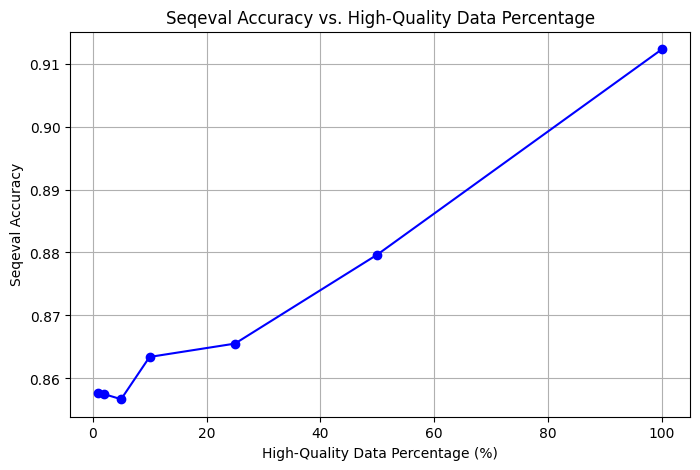

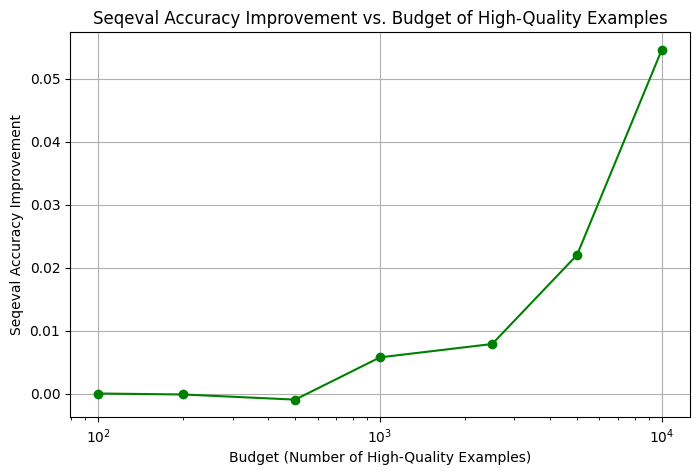

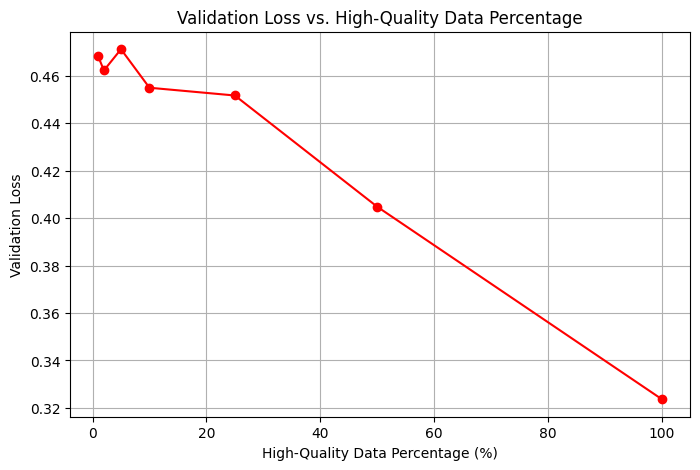

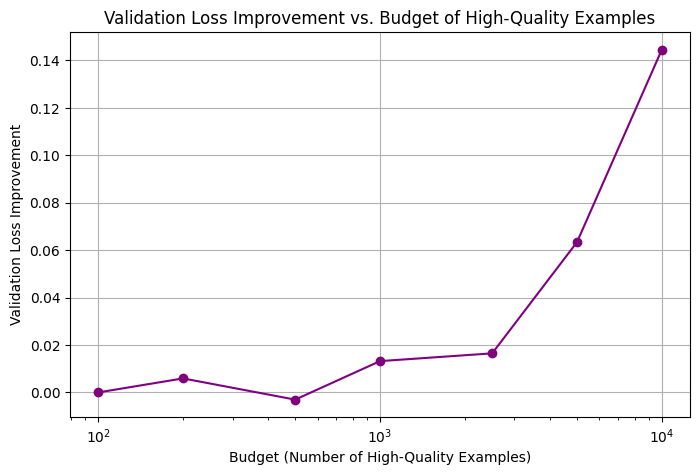

In [47]:
import matplotlib.pyplot as plt

percentages = [1, 2, 5, 10, 25, 50, 100]

# Budget (number of high-quality examples) corresponding to each percentage.
budgets = [100, 200, 500, 1000, 2500, 5000, 10000]

seqeval_scores = [metrics[1] for metrics in model_metrics]

validation_loss = [metrics[0] for metrics in model_metrics]

# Calculate improvement for seqeval accuracy relative to the baseline (1% high-quality data).
# Improvement is measured as the increase in seqeval accuracy.
seqeval_improvement = [score - seqeval_scores[0] for score in seqeval_scores]

# Calculate improvement for validation loss relative to the baseline.
# Here, improvement is measured as the reduction in loss (baseline loss minus current loss).
loss_improvement = [validation_loss[0] - loss for loss in validation_loss]

# -------------------------------
# Plot 1: Seqeval Accuracy vs. High-Quality Data Percentage.
# -------------------------------
plt.figure(figsize=(8, 5))
plt.plot(percentages, seqeval_scores, marker='o', linestyle='-', color='blue')
plt.title('Seqeval Accuracy vs. High-Quality Data Percentage')
plt.xlabel('High-Quality Data Percentage (%)')
plt.ylabel('Seqeval Accuracy')
plt.grid(True)
plt.show()

# -------------------------------
# Plot 2: Seqeval Accuracy Improvement vs. Budget of High-Quality Examples.
# -------------------------------
plt.figure(figsize=(8, 5))
plt.plot(budgets, seqeval_improvement, marker='o', linestyle='-', color='green')
plt.title('Seqeval Accuracy Improvement vs. Budget of High-Quality Examples')
plt.xlabel('Budget (Number of High-Quality Examples)')
plt.ylabel('Seqeval Accuracy Improvement')
plt.grid(True)
plt.xscale('log')  # Logarithmic scale
plt.show()

# -------------------------------
# Plot 3: Validation Loss vs. High-Quality Data Percentage.
# -------------------------------
plt.figure(figsize=(8, 5))
plt.plot(percentages, validation_loss, marker='o', linestyle='-', color='red')
plt.title('Validation Loss vs. High-Quality Data Percentage')
plt.xlabel('High-Quality Data Percentage (%)')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.show()

# -------------------------------
# Plot 4: Validation Loss Improvement vs. Budget of High-Quality Examples.
# -------------------------------
plt.figure(figsize=(8, 5))
plt.plot(budgets, loss_improvement, marker='o', linestyle='-', color='purple')
plt.title('Validation Loss Improvement vs. Budget of High-Quality Examples')
plt.xlabel('Budget (Number of High-Quality Examples)')
plt.ylabel('Validation Loss Improvement')
plt.grid(True)
plt.xscale('log')
plt.show()



## Results

There is a clear positive correlation between the percentage of high-quality data in the training set and the model’s performance on the named entity recognition task. Below is a detailed breakdown of the key observations based on the provided validation loss, seqeval accuracy, F1-Score, and classification reports.

We see that the validation loss is highest when only a minimal fraction of high-quality data is used. As the proportion of high-quality data increases, the validation loss steadily decreases.


### Classification Reports
A closer examination of the classification reports reveals that:
- *PER (Person)* often achieves relatively high precision and recall, reflecting the model’s strength in recognizing well-represented classes.
- *LOC (Location)* and *ORG (Organization)* generally improve as the quality and quantity of training data increase, though their performance may lag behind PER if fewer high-quality examples are available.

### Budget Analysis
The *Validation Loss Improvement vs. Budget* and *Seqeval Accuracy Improvement vs. Budget* plots highlight that, while adding high-quality data initially offers substantial gains, the marginal improvement tapers off once the model has sufficient representative examples. This pattern underlines the necessity of strategically allocating annotation resources to maximize the benefit of each additional high-quality example.

### Overall Conclusion
In summary, augmenting the training set with high-quality data significantly boosts the model’s performance on named entity recognition tasks. Early additions of well-annotated examples yield the most pronounced gains in validation loss reduction and seqeval accuracy improvement. As the volume of high-quality data grows, improvements become more incremental.

Additional


In [ ]:
MODEL_METRICS = [(0.46816145548453697,
  0.8576702447890043,
  0.6460790273556231,
  {'CLS]': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8},
   'LOC': {'precision': 0.7861822513400833,
    'recall': 0.7947019867549668,
    'f1-score': 0.7904191616766467,
    'support': 1661},
   'MISC': {'precision': 0.4244332493702771,
    'recall': 0.3176248821866164,
    'f1-score': 0.36334231805929923,
    'support': 1061},
   'ORG': {'precision': 0.550624133148405,
    'recall': 0.48651960784313725,
    'f1-score': 0.5165907612231619,
    'support': 816},
   'PER': {'precision': 0.9054054054054054,
    'recall': 0.7371638141809291,
    'f1-score': 0.81266846361186,
    'support': 818},
   'SEP]': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1},
   'micro avg': {'precision': 0.6883419689119171,
    'recall': 0.6087056128293241,
    'f1-score': 0.6460790273556231,
    'support': 4365},
   'macro avg': {'precision': 0.4444408398773618,
    'recall': 0.38933504849427497,
    'f1-score': 0.4138367840951613,
    'support': 4365},
   'weighted avg': {'precision': 0.6749377574635653,
    'recall': 0.6087056128293241,
    'f1-score': 0.637959516929766,
    'support': 4365}}),
 (0.4622469273897318,
  0.8575155417406749,
  0.6433249370277079,
  {'CLS]': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8},
   'LOC': {'precision': 0.8261421319796954,
    'recall': 0.7745389649018442,
    'f1-score': 0.7995087503837888,
    'support': 1681},
   'MISC': {'precision': 0.4391304347826087,
    'recall': 0.18967136150234742,
    'f1-score': 0.26491803278688525,
    'support': 1065},
   'ORG': {'precision': 0.559228650137741,
    'recall': 0.4969400244798042,
    'f1-score': 0.5262475696694751,
    'support': 817},
   'PER': {'precision': 0.8552456839309429,
    'recall': 0.7549824150058617,
    'f1-score': 0.8019925280199253,
    'support': 853},
   'SEP]': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1},
   'micro avg': {'precision': 0.7266002844950213,
    'recall': 0.5771751412429379,
    'f1-score': 0.6433249370277079,
    'support': 4425},
   'macro avg': {'precision': 0.44662448347183137,
    'recall': 0.3693554609816429,
    'f1-score': 0.39877781347667907,
    'support': 4425},
   'weighted avg': {'precision': 0.6876459237190904,
    'recall': 0.5771751412429379,
    'f1-score': 0.619244249747828,
    'support': 4425}}),
 (0.4711888316851943,
  0.856698487611284,
  0.6412419019679746,
  {'CLS]': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8},
   'LOC': {'precision': 0.7811447811447811,
    'recall': 0.8060220034742328,
    'f1-score': 0.7933884297520661,
    'support': 1727},
   'MISC': {'precision': 0.44054054054054054,
    'recall': 0.15219421101774042,
    'f1-score': 0.22623178348369188,
    'support': 1071},
   'ORG': {'precision': 0.5242047026279392,
    'recall': 0.4638922888616891,
    'f1-score': 0.4922077922077922,
    'support': 817},
   'PER': {'precision': 0.9041994750656168,
    'recall': 0.7489130434782608,
    'f1-score': 0.8192627824019024,
    'support': 920},
   'SEP]': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1},
   'micro avg': {'precision': 0.721198790211713,
    'recall': 0.5772447183098591,
    'f1-score': 0.6412419019679746,
    'support': 4544},
   'macro avg': {'precision': 0.44168158322981294,
    'recall': 0.36183692447198723,
    'f1-score': 0.3885151313075755,
    'support': 4544},
   'weighted avg': {'precision': 0.6780358087727443,
    'recall': 0.5772447183098591,
    'f1-score': 0.6092279014824755,
    'support': 4544}}),
 (0.45495213461773737,
  0.8634129213483146,
  0.6553545342173278,
  {'CLS]': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8},
   'LOC': {'precision': 0.8153935185185185,
    'recall': 0.7875908328675237,
    'f1-score': 0.8012510662496446,
    'support': 1789},
   'MISC': {'precision': 0.4105409153952843,
    'recall': 0.2730627306273063,
    'f1-score': 0.32797783933518004,
    'support': 1084},
   'ORG': {'precision': 0.5378787878787878,
    'recall': 0.4913494809688581,
    'f1-score': 0.5135623869801085,
    'support': 867},
   'PER': {'precision': 0.8790593505039194,
    'recall': 0.7726377952755905,
    'f1-score': 0.822420115243583,
    'support': 1016},
   'SEP]': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1},
   'micro avg': {'precision': 0.7053701015965167,
    'recall': 0.6119622245540399,
    'f1-score': 0.6553545342173278,
    'support': 4765},
   'macro avg': {'precision': 0.4404787620494183,
    'recall': 0.3874401399565464,
    'f1-score': 0.41086856796808596,
    'support': 4765},
   'weighted avg': {'precision': 0.6848332772551959,
    'recall': 0.6119622245540399,
    'f1-score': 0.6442399920166177,
    'support': 4765}}),
 (0.4516798326745629,
  0.8655313645182151,
  0.6372648189358688,
  {'CLS]': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8},
   'LOC': {'precision': 0.7199440820130475,
    'recall': 0.8001035732780942,
    'f1-score': 0.7579102281089035,
    'support': 1931},
   'MISC': {'precision': 0.38003220611916266,
    'recall': 0.2116591928251121,
    'f1-score': 0.271889400921659,
    'support': 1115},
   'ORG': {'precision': 0.5273775216138329,
    'recall': 0.36273538156590684,
    'f1-score': 0.4298297122724604,
    'support': 1009},
   'PER': {'precision': 0.8995515695067264,
    'recall': 0.804975922953451,
    'f1-score': 0.8496399830580262,
    'support': 1246},
   'SEP]': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1},
   'micro avg': {'precision': 0.6883741258741258,
    'recall': 0.5932203389830508,
    'f1-score': 0.6372648189358688,
    'support': 5310},
   'macro avg': {'precision': 0.42115089654212823,
    'recall': 0.36324567843709404,
    'f1-score': 0.3848782207268415,
    'support': 5310},
   'weighted avg': {'precision': 0.6529026567050471,
    'recall': 0.5932203389830508,
    'f1-score': 0.6137534710130237,
    'support': 5310}}),
 (0.40479272200415534,
  0.8796663751933813,
  0.6462718515875847,
  {'CLS]': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8},
   'LOC': {'precision': 0.7318511796733213,
    'recall': 0.7666349809885932,
    'f1-score': 0.7488393686165274,
    'support': 2104},
   'MISC': {'precision': 0.4531914893617021,
    'recall': 0.17012779552715654,
    'f1-score': 0.24738675958188153,
    'support': 1252},
   'ORG': {'precision': 0.6033934252386002,
    'recall': 0.42148148148148146,
    'f1-score': 0.4962930658525948,
    'support': 1350},
   'PER': {'precision': 0.8765167737330478,
    'recall': 0.830290736984449,
    'f1-score': 0.852777777777778,
    'support': 1479},
   'SEP]': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1},
   'micro avg': {'precision': 0.7220007971303308,
    'recall': 0.5849208911850178,
    'f1-score': 0.6462718515875847,
    'support': 6194},
   'macro avg': {'precision': 0.44415881133444524,
    'recall': 0.36475583249694665,
    'f1-score': 0.3908828286381303,
    'support': 6194},
   'weighted avg': {'precision': 0.6810074360892487,
    'recall': 0.5849208911850178,
    'f1-score': 0.6161672952534754,
    'support': 6194}}),
 (0.32363375124987215,
  0.9122832949722322,
  0.6670534484008994,
  {'CLS]': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8},
   'LOC': {'precision': 0.7866880513231757,
    'recall': 0.7348314606741573,
    'f1-score': 0.7598760650658404,
    'support': 2670},
   'MISC': {'precision': 0.49122807017543857,
    'recall': 0.22626262626262628,
    'f1-score': 0.30982019363762103,
    'support': 1485},
   'ORG': {'precision': 0.6191489361702127,
    'recall': 0.5060869565217392,
    'f1-score': 0.5569377990430622,
    'support': 1725},
   'PER': {'precision': 0.9315068493150684,
    'recall': 0.8026981450252951,
    'f1-score': 0.8623188405797101,
    'support': 1779},
   'SEP]': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1},
   'micro avg': {'precision': 0.7513478189838262,
    'recall': 0.5997652582159625,
    'f1-score': 0.6670534484008994,
    'support': 7668},
   'macro avg': {'precision': 0.4714286511639825,
    'recall': 0.3783131980806363,
    'f1-score': 0.4148254830543723,
    'support': 7668},
   'weighted avg': {'precision': 0.7244540142238561,
    'recall': 0.5997652582159625,
    'f1-score': 0.6499393586356609,
    'support': 7668}})]
